## Does weather play a factor in when deliveries occur?

In [1]:
#Import Libraries
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,LogisticRegressionCV,LassoCV,ElasticNet,ElasticNetCV,RidgeCV,RidgeClassifierCV,ridge_regression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score,cross_val_predict,RepeatedStratifiedKFold,RepeatedKFold
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier, RandomForestRegressor
#need "pip install scikit-optimize"
from skopt.searchcv import BayesSearchCV
from skopt.space import Integer, Real, Categorical 
from skopt.utils import use_named_args
from skopt import gp_minimize
from timeit import default_timer as timer
from sklearn import tree
import graphviz
import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
#load dataset into a dataframe and confirm values
full_start = timer()
df_raw = pd.read_csv('DataSets\\Savage_Daily_Ticket_Count_Weather_Export.csv')
df_raw.head(12)

,delivery_count_sum,is_above_average_delivery_day,log_ratio_to_average,delivery_date,delivery_weekday_name,is_midweek,DailyPrecipitation,DailySnowDepth,SnowOnGround,DailySnowfall,...,PriorDayPrecipitationAmt,Prior2DayPrecipitationAmt,PriorDayPrecipitationDiff,Prior2DayPrecipitationDiff,PriorDaySnowfallAmt,PriorDaySnowfallDiff,Precip_12AM-6AM,Precip_6AM-10AM,Precip_6AM-12PM,Precip_10AM-2PM
0,2,False,0.000000,2021-01-07,Thu,True,0.00,8,True,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,No Precip,No Precip,No Precip,No Precip
1,2,False,0.000000,2020-01-10,Fri,False,0.00,3,True,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,No Precip,No Precip,No Precip,No Precip
2,1,False,0.000000,2011-01-13,Thu,True,0.08,10,True,1.9,...,0.00,0.10,0.08,-0.02,0.0,1.9,No Precip,No Precip,Light Precip,Precip
3,1,False,0.000000,2011-01-24,Mon,False,0.01,12,True,0.1,...,0.00,0.00,0.01,0.01,0.0,0.1,No Precip,No Precip,No Precip,Light Precip
4,2,False,0.000000,2018-01-31,Wed,True,0.13,5,True,2.1,...,0.00,0.00,0.13,0.13,0.0,2.1,Precip,No Precip,No Precip,No Precip
5,1,False,0.000000,2013-02-06,Wed,True,0.04,5,True,0.7,...,0.05,0.06,-0.01,-0.02,1.2,-0.5,No Precip,No Precip,Light Precip,Light Precip
6,2,False,0.000000,2017-02-09,Thu,True,0.00,0,False,0.0,...,0.00,0.01,0.00,-0.01,0.0,0.0,No Precip,No Precip,No Precip,No Precip
7,1,False,0.000000,2020-02-13,Thu,True,0.00,9,True,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,No Precip,No Precip,No Precip,No Precip
8,12,False,0.000000,2016-02-25,Thu,True,0.00,0,False,0.0,...,0.00,0.04,0.00,-0.04,0.0,0.0,No Precip,No Precip,No Precip,No Precip
9,5,False,-0.903090,2013-02-26,Tue,True,0.00,6,True,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,No Precip,No Precip,No Precip,No Precip


Response varaibles are:  
delivery_count_sum -> total deliveries for the date

log_ratio_to_average -> ratio of today's deliveries to the average on that day for the last 11 years (log transformed to normallize)

is_above_average_delivery_day -> to try logistic regression:  True if greater than the average

In [3]:
#establish the working set
df = df_raw.copy()

#don't need the delivery date field for analysis nor the day name
df = df.drop(['delivery_date','delivery_weekday_name'],axis=1)

#set values to string for analysis
df['SnowOnGround'] = df['SnowOnGround'].astype(str)
df['is_midweek'] = df['is_midweek'].astype(str)


In [4]:
#Correlations have been checked in dataset building, but will put a matrix up for completeness
corr = df_raw.corr()
corr.style.background_gradient(cmap='coolwarm')

,delivery_count_sum,is_above_average_delivery_day,log_ratio_to_average,is_midweek,DailyPrecipitation,DailySnowDepth,SnowOnGround,DailySnowfall,PriorDayAverageDryBulbTemperatureDiff,PriorDayMaximumTemperatureDiff,PriorDayMinimumTemperatureDiff,PriorDayPrecipitationAmt,Prior2DayPrecipitationAmt,PriorDayPrecipitationDiff,Prior2DayPrecipitationDiff,PriorDaySnowfallAmt,PriorDaySnowfallDiff
delivery_count_sum,1.000000,0.699812,0.684540,0.033508,0.013602,-0.180256,-0.209841,-0.092842,0.017620,0.013661,0.018282,0.015692,0.056086,-0.002015,-0.030033,-0.093728,-0.005833
is_above_average_delivery_day,0.699812,1.000000,0.715765,0.039456,-0.012871,-0.107103,-0.104156,-0.067173,0.002460,-0.003605,0.008667,-0.011272,0.006752,-0.000803,-0.013905,-0.056636,-0.012099
log_ratio_to_average,0.684540,0.715765,1.000000,0.010904,-0.026159,-0.140165,-0.137056,-0.085994,0.002544,-0.000205,0.007628,-0.036993,-0.002928,0.009038,-0.016482,-0.111550,0.012032
is_midweek,0.033508,0.039456,0.010904,1.000000,0.042467,0.033734,0.039789,0.010758,-0.031163,-0.045758,-0.002174,0.011202,0.008966,0.022340,0.023776,0.010489,0.000938
DailyPrecipitation,0.013602,-0.012871,-0.026159,0.042467,1.000000,-0.046065,-0.053277,0.129491,-0.108592,-0.148424,-0.016733,0.091786,0.003535,0.656371,0.706736,-0.023907,0.117129
DailySnowDepth,-0.180256,-0.107103,-0.140165,0.033734,-0.046065,1.000000,0.774955,0.160079,0.038992,0.028297,0.042128,-0.018210,-0.024930,-0.019643,-0.015033,0.375478,-0.140689
SnowOnGround,-0.209841,-0.104156,-0.137056,0.039789,-0.053277,0.774955,1.000000,0.238799,0.030078,0.020095,0.032926,-0.024059,-0.025300,-0.020447,-0.019887,0.374648,-0.079143
DailySnowfall,-0.092842,-0.067173,-0.085994,0.010758,0.129491,0.160079,0.238799,1.000000,-0.065219,-0.090589,-0.007391,-0.007207,-0.029462,0.099459,0.112684,0.088407,0.712090
PriorDayAverageDryBulbTemperatureDiff,0.017620,0.002460,0.002544,-0.031163,-0.108592,0.038992,0.030078,-0.065219,1.000000,0.897599,0.805128,-0.086567,-0.013921,-0.013242,-0.067169,-0.050120,-0.015179
PriorDayMaximumTemperatureDiff,0.013661,-0.003605,-0.000205,-0.045758,-0.148424,0.028297,0.020095,-0.090589,0.897599,1.000000,0.466969,-0.042807,0.026282,-0.075310,-0.123862,-0.022967,-0.053964


In [5]:
#function to handle multi-collinearity tests
def vif_calc(X):
    vif_info = pd.DataFrame()
    vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif_info['Column'] = X.columns
    vif_info.sort_values('VIF', ascending=False)
    return(vif_info)

#function to pass back AIC for linear model

def aic_calc(X,Y):
    #add constant to predictor variables
    X = sm.add_constant(X)
    #fit regression model
    model = sm.OLS(Y, X).fit()
    return(model.aic)


In [6]:
#create data sets for analysis, keep x's separate in case I change individual tests first is regression against the delivery count
xc_full = df.drop(['delivery_count_sum','is_above_average_delivery_day','log_ratio_to_average'],axis=1)
xc_full = pd.get_dummies(xc_full,drop_first = True)                #make dummies for categorical values for analysis
yc = df['delivery_count_sum']

In [7]:
vif_calc(xc_full)

,VIF,Column
0,inf,DailyPrecipitation
1,2.696621,DailySnowDepth
2,inf,DailySnowfall
3,265.041789,PriorDayAverageDryBulbTemperatureDiff
4,119.189091,PriorDayMaximumTemperatureDiff
5,65.842482,PriorDayMinimumTemperatureDiff
6,inf,PriorDayPrecipitationAmt
7,inf,Prior2DayPrecipitationAmt
8,inf,PriorDayPrecipitationDiff
9,inf,Prior2DayPrecipitationDiff


This data (as expected) has columns that have correlations.  In general the "Diff" fields are better distributed than the "Amt" so we will remove and run this again.  Also remove the "no precip" fields since they have high correlations.

In [8]:
temp_xc = xc_full.drop(['PriorDayPrecipitationAmt','Prior2DayPrecipitationAmt','PriorDaySnowfallAmt','Precip_12AM-6AM_No Precip','Precip_6AM-10AM_No Precip','Precip_6AM-12PM_No Precip','Precip_10AM-2PM_No Precip'],axis=1)
vif_calc(temp_xc)

,VIF,Column
0,3.688010,DailyPrecipitation
1,2.691790,DailySnowDepth
2,2.602310,DailySnowfall
3,264.790860,PriorDayAverageDryBulbTemperatureDiff
4,119.023235,PriorDayMaximumTemperatureDiff
5,65.791737,PriorDayMinimumTemperatureDiff
6,1.812148,PriorDayPrecipitationDiff
7,1.974165,Prior2DayPrecipitationDiff
8,2.454478,PriorDaySnowfallDiff
9,1.247900,is_midweek_True


All looking good except need to pick which Temperature Diff field to keep. Check for lowest AIC from keeping 1 of them.

In [9]:
aic_val =np.empty(4)
aic_val[0] = aic_calc(temp_xc,yc)
temp_x = temp_xc.drop(['PriorDayMaximumTemperatureDiff','PriorDayMinimumTemperatureDiff'],axis=1)
aic_val[1] = aic_calc(temp_x,yc)
temp_x = temp_xc.drop(['PriorDayMinimumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
aic_val[2] = aic_calc(temp_x,yc)
temp_x = temp_xc.drop(['PriorDayMaximumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
aic_val[3] = aic_calc(temp_x,yc)
print(aic_val)

[27572.1525601  27568.91203952 27569.73295657 27568.29817082]


In [10]:
xc_part = temp_xc.drop(['PriorDayMaximumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
vif_calc(xc_part)

,VIF,Column
0,3.685394,DailyPrecipitation
1,2.690219,DailySnowDepth
2,2.594989,DailySnowfall
3,1.026933,PriorDayMinimumTemperatureDiff
4,1.811045,PriorDayPrecipitationDiff
5,1.963905,Prior2DayPrecipitationDiff
6,2.453428,PriorDaySnowfallDiff
7,1.246875,is_midweek_True
8,2.843407,SnowOnGround_True
9,1.395769,Precip_12AM-6AM_Precip


I now have a full datasets and a subset of data that has strong VIF stats.  I will run linear regression to get a baseline

In [11]:
#function to run baseline regression
def get_stats(x,y,log=False):
    if (log == True):
        results = sm.Logit(y,x).fit()
    else: results = sm.OLS(y,x).fit()
    print(results.summary())


In [12]:
#do linear regression on the full (for comparison) and then on the partial removing non-signficant p-values
#real models will have test/train data
get_stats(xc_full,yc)

get_stats(xc_part,yc) 
temp_xc = xc_part.drop(['PriorDaySnowfallDiff','Precip_10AM-2PM_Precip'],axis=1)
get_stats(temp_xc,yc) 

temp_xc = temp_xc.drop(['DailySnowDepth','DailySnowfall','Precip_6AM-10AM_Precip','Precip_6AM-12PM_Precip'],axis=1)
get_stats(temp_xc,yc) 

#capture the dataset used by linear regression
xc_sp = temp_xc


                                 OLS Regression Results                                
Dep. Variable:     delivery_count_sum   R-squared (uncentered):                   0.551
Model:                            OLS   Adj. R-squared (uncentered):              0.547
Method:                 Least Squares   F-statistic:                              143.3
Date:                Wed, 06 Apr 2022   Prob (F-statistic):                        0.00
Time:                        15:52:02   Log-Likelihood:                         -13779.
No. Observations:                2235   AIC:                                  2.760e+04
Df Residuals:                    2216   BIC:                                  2.770e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

set up models:  

Lasso & Elastic Net and "boosting" for of decisions trees for the full models (since they do various measures of feature selection) .

Ridge Regression and Random Forests for the partial datasets since they work better on models that don't have collinearity issues (which we've addressed).

In all cases, I will utilize cross validation on all the data to find the "Best" model, and then use a train/test set to get the  root mean squared error and R^2 values.

In [13]:
def graph_result(X,Y_test,Y_pred):
    x_ax = range(len(X))
    plt.scatter(x_ax, Y_test, s=5, color="navy", label="original")
    plt.plot(x_ax, Y_pred, lw=0.8, color="gold", label="predicted")
    plt.legend()
    plt.show()
    return()

def run_linear(X,Y,graph=False):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'fit_intercept' : [True,False],
        'positive' : [True,False]
    }    
    cv = KFold(n_splits = 10,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=LinearRegression(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=10,
        #scoring="accuracy",  -- leave as default which is based on the estimator
        verbose=0,
        random_state=5440
    )
    #scale the x predictor values and then run the Bayesian search and capture best parameters
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)       
    search.fit(x_scaled,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,Y,test_size=.24,random_state=5440)   

    model = LinearRegression(n_jobs=-1,fit_intercept=best_params['fit_intercept'],positive=best_params['positive'])
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    
    if graph:
        graph_result(x_test,y_test,pred_test)
    
    return(rmse_test,r2_test)
    
# function for fitting trees of various depths for Random Forests
def run_cross_validation_on_regression_RF(X, Y):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'n_estimators': [500,1000],
        'max_depth': (1, 9),
        'criterion': ['squared_error', 'absolute_error','mae']
    }
    cv = KFold(n_splits = 10,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=RandomForestRegressor(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=100,
        #scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    search.fit(X,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    model = RandomForestRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth']
                                   ,criterion=best_params['criterion'],max_features=.3333)
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)    
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    return(rmse_test,r2_test)

# function for fitting trees of various depths for Boosted Version
def run_cross_validation_on_regression_Boost(X, Y):
    #X = predictors, Y = response
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'n_estimators': [250, 500, 750, 1000],
        'max_depth': (1, 9),
        'criterion': ['friedman_mse','squared_error'],
        'loss' : ['squared_error','absolute_error','huber'],
        'max_features' : ['sqrt','log2']
    }    
    cv = KFold(n_splits = 10,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=GradientBoostingRegressor(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=200,
        #scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    search.fit(X,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    model = GradientBoostingRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth']
                                   ,criterion=best_params['criterion'],loss=best_params['loss'],max_features=best_params['max_features'])
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    return(rmse_test,r2_test)

#enet regression:  handles E-Net and Lasso
def run_enet_regression(X,Y,graph=False,iter_nbr=1000):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'alpha' : [.001,.01,.1,1.0,10.0,100.0],
        'l1_ratio' : [.01,.05,.1,.3,.5,.7,.9,.95,.99,1],
        'fit_intercept' : [True,False]
    }    
    cv = KFold(n_splits = 10,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=ElasticNet(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=100,
        #scoring="accuracy",  -- leave as default which is based on the estimator
        verbose=0,
        random_state=5440
    )
    #scale the x predictor values and then run the Bayesian search and capture best parameters
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)       
    search.fit(x_scaled,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,Y,test_size=.24,random_state=5440)   

    model = ElasticNet(fit_intercept=best_params['fit_intercept'],alpha=best_params['alpha'],
                         l1_ratio=best_params['l1_ratio'],random_state=5440)
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    
    if graph:
        graph_result(x_test,y_test,pred_test)
    
    return(rmse_test,r2_test)

#ridge regression:  handles Ridge separately due to different hyperparameters and lack of feature selection
def run_ridge_regression(X,Y,graph=False,iter_nbr=1000):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression

    #scale the x predictor values and then run the Bayesian search and capture best parameters
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)       
   
    cv = RepeatedKFold(n_splits = 10,n_repeats=50,random_state=5440)  
    model = RidgeCV(alphas=[.0001,.0005,.001,.005,.01,.05,.1,.5,1.0,5,10,50,100],cv=cv)
    model.fit(x_scaled,Y)
    print(model.alpha_)
    
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,Y,test_size=.24,random_state=5440)   

    pred_test = model.predict(x_test)
    rmse_test = np.sqrt(mean_squared_error(y_test,pred_test))
    r2_test = r2_score(y_test, pred_test)  
    
    if graph:
        graph_result(x_test,y_test,pred_test)
    
    return(rmse_test,r2_test)


In [14]:
# With the regression functions defined, run the regressions and capture the RMSE and R-squared
start = timer()
linear_rmse,linear_r2 = run_linear(xc_part,yc)
end = timer()
print(f'Linear Model on Data Subset Complete in {end-start} seconds')

start = timer()
linear_sp_rmse,linear_sp_r2 = run_linear(xc_sp,yc)
end = timer()
print(f'Linear Model on Significant P Values Complete in {end-start} seconds')

start = timer()      
enet_full_rmse,enet_full_r2 = run_enet_regression(xc_full,yc)
end = timer()
print(f'Enet Regression Model on Full Dataset Complete in {end-start} seconds')

start = timer()  
ridge_part_rmse,ridge_part_r2 = run_ridge_regression(xc_part,yc)
end = timer()
print(f'Ridge Regression Model on Data Subset Complete in {end-start} seconds')

start = timer()  
rfr_rmse,rfr_r2 = run_cross_validation_on_regression_RF(xc_part,yc)
end = timer()
print(f'Random Forest Model on Data Subset Complete in {end-start} seconds')

start = timer()  
boost_rmse,boost_r2 = run_cross_validation_on_regression_Boost(xc_full,yc)
end = timer()
print(f'Boosted Trees Model on Full Dataset Complete in {end-start} seconds')

start = timer()  
boost_part_rmse,boost_part_r2 = run_cross_validation_on_regression_Boost(xc_part,yc)
end = timer()
print(f'Boosted Trees Model on Data Subset Complete in {end-start} seconds')

OrderedDict([('fit_intercept', True), ('positive', False)])
Linear Model on Data Subset Complete in 3.1630635000000007 seconds
OrderedDict([('fit_intercept', True), ('positive', False)])
Linear Model on Significant P Values Complete in 0.5912059000000003 seconds
OrderedDict([('alpha', 1.0), ('fit_intercept', True), ('l1_ratio', 0.95)])
Enet Regression Model on Full Dataset Complete in 154.41904630000002 seconds
100.0
Ridge Regression Model on Data Subset Complete in 9.108241099999987 seconds
OrderedDict([('criterion', 'squared_error'), ('max_depth', 4), ('n_estimators', 1000)])
Random Forest Model on Data Subset Complete in 1417.3346632 seconds
OrderedDict([('criterion', 'squared_error'), ('loss', 'squared_error'), ('max_depth', 1), ('max_features', 'sqrt'), ('n_estimators', 250)])
Boosted Trees Model on Full Dataset Complete in 996.5102790999999 seconds
OrderedDict([('criterion', 'squared_error'), ('loss', 'squared_error'), ('max_depth', 1), ('max_features', 'log2'), ('n_estimators', 

In [15]:
#create a data frame of the results for analysis
result_ds_list  = [['Linear Run 1','Subset',linear_rmse,linear_r2]
                  ,['Linear Run 2','Sig_P_Only',linear_sp_rmse,linear_sp_r2]
                  ,['ENet Run 1','Full',enet_full_rmse,enet_full_r2]
                  ,['Ridge Run 1','Subset',ridge_part_rmse,ridge_part_r2]
                  ,['Random Forest Run 1','Subset',rfr_rmse,rfr_r2]
                  ,['Boosted Trees Run 1','Full',boost_rmse,boost_r2]
                  ,['Boosted Trees Run 2','Subset',boost_part_rmse,boost_part_r2]]
results_delivery_count = pd.DataFrame(result_ds_list,columns=['Model_Name','Data_Used','RMSE','R_Squared'])
results_delivery_count.sort_values(['RMSE','R_Squared'],ascending=[True,False])

,Model_Name,Data_Used,RMSE,R_Squared
3,Ridge Run 1,Subset,112.884937,0.054328
4,Random Forest Run 1,Subset,113.200128,0.049040
6,Boosted Trees Run 2,Subset,113.333040,0.046805
2,ENet Run 1,Full,113.427013,0.045224
1,Linear Run 2,Sig_P_Only,113.439357,0.045016
0,Linear Run 1,Subset,113.507471,0.043869
5,Boosted Trees Run 1,Full,113.806949,0.038817


There doesn't look to be any predictive power in looking at weather against the daily delivery count.  Next we will look at the ratio of that days loads above average.  I will use the same methods to develop the datasets and run the same tests.  

In [16]:
xr_full = df.drop(['delivery_count_sum','is_above_average_delivery_day','log_ratio_to_average'],axis=1)
xr_full = pd.get_dummies(xr_full,drop_first = True)                #make dummies for categorical values for analysis
yr = df['log_ratio_to_average']
xr_part = xr_full.drop(['PriorDayPrecipitationAmt','Prior2DayPrecipitationAmt','PriorDaySnowfallAmt','Precip_12AM-6AM_No Precip','Precip_6AM-10AM_No Precip','Precip_6AM-12PM_No Precip','Precip_10AM-2PM_No Precip'],axis=1)
vif_calc(xr_part)

aic_val =np.empty(4)
aic_val[0] = aic_calc(xr_part,yr)
temp_x = xr_part.drop(['PriorDayMaximumTemperatureDiff','PriorDayMinimumTemperatureDiff'],axis=1)
aic_val[1] = aic_calc(temp_x,yr)
temp_x = xr_part.drop(['PriorDayMinimumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
aic_val[2] = aic_calc(temp_x,yr)
temp_x = xr_part.drop(['PriorDayMaximumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
aic_val[3] = aic_calc(temp_x,yr)
print(aic_val)

xr_part = xr_part.drop(['PriorDayMinimumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
vif_calc(xr_part)

[3260.91960117 3258.25869181 3258.13880788 3258.28616675]


,VIF,Column
0,3.674388,DailyPrecipitation
1,2.687894,DailySnowDepth
2,2.596317,DailySnowfall
3,1.051683,PriorDayMaximumTemperatureDiff
4,1.796038,PriorDayPrecipitationDiff
5,1.962646,Prior2DayPrecipitationDiff
6,2.441150,PriorDaySnowfallDiff
7,1.246911,is_midweek_True
8,2.843687,SnowOnGround_True
9,1.396611,Precip_12AM-6AM_Precip


In [17]:
#get the significant variables for linear regression and find the proper tuning parametners for Lasso/E-Net
get_stats(xr_part,yr) 
temp_xr = xr_part.drop(['PriorDayMaximumTemperatureDiff','Precip_12AM-6AM_Precip','Precip_6AM-10AM_Precip','Precip_6AM-12PM_Precip','Precip_10AM-2PM_Precip'],axis=1)
get_stats(temp_xr,yr)
xr_sp = temp_xr

#run_lasso(xr_full,yr,iter_nbr=5000,a_start = .001,a_stop = .01,a_step=.001)
#run_elastic_net(xr_full,yr,scaling_list=[.01,.02,.03,.04,.05,.06,.07,.08,.09,.1],iter_nbr=5000)
#run_ridge(xr_part,yr,a_start = 90,a_stop = 100,a_step=.1)

                                  OLS Regression Results                                 
Dep. Variable:     log_ratio_to_average   R-squared (uncentered):                   0.126
Model:                              OLS   Adj. R-squared (uncentered):              0.121
Method:                   Least Squares   F-statistic:                              24.64
Date:                  Wed, 06 Apr 2022   Prob (F-statistic):                    2.44e-56
Time:                          16:52:10   Log-Likelihood:                         -1668.8
No. Observations:                  2235   AIC:                                      3364.
Df Residuals:                      2222   BIC:                                      3438.
Df Model:                            13                                                  
Covariance Type:              nonrobust                                                  
                                     coef    std err          t      P>|t|      [0.025      0.975]
-

In [18]:
# With the regression functions defined, run the regressions and capture the RMSE and R-squared
start = timer()
linear_rmse,linear_r2 = run_linear(xr_part,yr)
end = timer()
print(f'Linear Model on Data Subset Complete in {end-start} seconds')

start = timer()
linear_sp_rmse,linear_sp_r2 = run_linear(xr_sp,yr)
end = timer()
print(f'Linear Model on Significant P Values Complete in {end-start} seconds')

start = timer()
enet_full_rmse,enet_full_r2 = run_enet_regression(xr_full,yr)
end = timer()
print(f'Enet Regression Model on Full Dataset Complete in {end-start} seconds')

start = timer()
ridge_part_rmse,ridge_part_r2 = run_ridge_regression(xr_part,yr)
end = timer()
print(f'Ridge Regression Model on Data Subset Complete in {end-start} seconds')

start = timer()
rfr_rmse,rfr_r2 = run_cross_validation_on_regression_RF(xr_part,yr)
end = timer()
print(f'Random Forest Model on Data Subset Complete in {end-start} seconds')

start = timer()
boost_rmse,boost_r2 = run_cross_validation_on_regression_Boost(xr_full,yr)
end = timer()
print(f'Boosted Trees Model on Full Dataset Complete in {end-start} seconds')

start = timer()
boost_part_rmse,boost_part_r2 = run_cross_validation_on_regression_Boost(xr_part,yr)
end = timer()
print(f'Boosted Trees Model on Data Subset Complete in {end-start} seconds')

OrderedDict([('fit_intercept', True), ('positive', False)])
Linear Model on Data Subset Complete in 0.6679791999999907 seconds
OrderedDict([('fit_intercept', True), ('positive', False)])
Linear Model on Significant P Values Complete in 0.6797299999998359 seconds
OrderedDict([('alpha', 0.01), ('fit_intercept', True), ('l1_ratio', 0.7)])
Enet Regression Model on Full Dataset Complete in 168.1716446999999 seconds
100.0
Ridge Regression Model on Data Subset Complete in 8.976221599999917 seconds
OrderedDict([('criterion', 'squared_error'), ('max_depth', 3), ('n_estimators', 500)])
Random Forest Model on Data Subset Complete in 1674.5786593999997 seconds
OrderedDict([('criterion', 'friedman_mse'), ('loss', 'squared_error'), ('max_depth', 1), ('max_features', 'log2'), ('n_estimators', 250)])
Boosted Trees Model on Full Dataset Complete in 992.0454024999999 seconds
OrderedDict([('criterion', 'squared_error'), ('loss', 'squared_error'), ('max_depth', 1), ('max_features', 'sqrt'), ('n_estimators

In [19]:
#create a data frame of the results for analysis
result_ra_list  = [['Linear Run 1','Subset',linear_rmse,linear_r2]
                  ,['Linear Run 2','Sig_P_Only',linear_sp_rmse,linear_sp_r2]
                  ,['Enet Run 1','Full',enet_full_rmse,enet_full_r2]
                  ,['Ridge Run 1','Subset',ridge_part_rmse,ridge_part_r2]
                  ,['Random Forest Run 1','Subset',rfr_rmse,rfr_r2]
                  ,['Boosted Trees Run 1','Full',boost_rmse,boost_r2]
                  ,['Boosted Trees Run 2','Subset',boost_part_rmse,boost_part_r2]]
results_delivery_count = pd.DataFrame(result_ra_list,columns=['Model_Name','Data_Used','RMSE','R_Squared'])
results_delivery_count.sort_values(['RMSE','R_Squared'],ascending=[True,False])

,Model_Name,Data_Used,RMSE,R_Squared
3,Ridge Run 1,Subset,0.500730,0.022523
5,Boosted Trees Run 1,Full,0.502741,0.014656
2,Enet Run 1,Full,0.502775,0.014521
4,Random Forest Run 1,Subset,0.503299,0.012466
0,Linear Run 1,Subset,0.503387,0.012119
1,Linear Run 2,Sig_P_Only,0.503674,0.010994
6,Boosted Trees Run 2,Subset,0.504282,0.008603


Actually worse values.  A bit suprised the ensemble methods are not doing better.  Next step will do a logistic/classification.

In [20]:
xl_full = df.drop(['delivery_count_sum','is_above_average_delivery_day','log_ratio_to_average'],axis=1)
xl_full = pd.get_dummies(xl_full,drop_first = True)                #make dummies for categorical values for analysis
yl = df['is_above_average_delivery_day']

xl_part = xl_full.drop(['PriorDayPrecipitationAmt','Prior2DayPrecipitationAmt','PriorDaySnowfallAmt','Precip_12AM-6AM_No Precip','Precip_6AM-10AM_No Precip','Precip_6AM-12PM_No Precip','Precip_10AM-2PM_No Precip'],axis=1)
vif_calc(xl_part)

aic_val =np.empty(4)
aic_val[0] = aic_calc(xl_part,yl)
temp_x = xl_part.drop(['PriorDayMaximumTemperatureDiff','PriorDayMinimumTemperatureDiff'],axis=1)
aic_val[1] = aic_calc(temp_x,yl)
temp_x = xl_part.drop(['PriorDayMinimumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
aic_val[2] = aic_calc(temp_x,yl)
temp_x = xl_part.drop(['PriorDayMaximumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
aic_val[3] = aic_calc(temp_x,yl)
print(aic_val)

xl_part = xl_part.drop(['PriorDayMaximumTemperatureDiff','PriorDayAverageDryBulbTemperatureDiff'],axis=1)
vif_calc(xl_part)

[3171.86520267 3168.76147696 3168.59722688 3168.52102732]


,VIF,Column
0,3.685394,DailyPrecipitation
1,2.690219,DailySnowDepth
2,2.594989,DailySnowfall
3,1.026933,PriorDayMinimumTemperatureDiff
4,1.811045,PriorDayPrecipitationDiff
5,1.963905,Prior2DayPrecipitationDiff
6,2.453428,PriorDaySnowfallDiff
7,1.246875,is_midweek_True
8,2.843407,SnowOnGround_True
9,1.395769,Precip_12AM-6AM_Precip


Going to utilize 2 datasets in this case -- removing the multi-collinearity is the biggest thing.  Will do a similar bag of models.

In [21]:
def run_logistic(X,Y,graph=False,iter_nbr=100):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'fit_intercept' : [True,False],
        'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }    
    cv = StratifiedKFold(n_splits = 10,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=LogisticRegressionCV(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=50,
        scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    #scale the x predictor values and then run the Bayesian search and capture best parameters
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)       
    search.fit(x_scaled,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,Y,test_size=.24,random_state=5440)
    model = LogisticRegressionCV(cv=cv,fit_intercept=best_params['fit_intercept']
                                 ,solver=best_params['solver'],scoring='accuracy',max_iter=iter_nbr,n_jobs=-1)
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    test_score = model.score(x_test,y_test)
      
    if graph:
        cm = confusion_matrix(y_test,pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        disp.plot(cmap='BuGn')
        plt.show()

    return(test_score)

# function for fitting trees of various depths using cross-validation
def run_cross_validation_on_classification_RF(X, Y,scoring='accuracy',iter_nbr=500,graph=False):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'n_estimators': [500, 1000],
        'max_depth': (1, 9),
        'criterion': ['gini', 'entropy']
    }    
    cv = StratifiedKFold(n_splits = 10,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=RandomForestClassifier(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=100,     
        scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    search.fit(X,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    model = RandomForestClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth']
                                   ,criterion=best_params['criterion'],max_features=.3333)
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    test_score = model.score(x_test,y_test)
      
    if graph:
        cm = confusion_matrix(y_test,pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        disp.plot(cmap='BuGn')
        plt.show()

    return(test_score)

def run_cross_validation_on_classification_Boost(X, Y,scoring='accuracy',iter_nbr=500,graph=False):
    #X = predictors, Y = response, log determines if we are using linear or logistic regression
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search   
    hyper_params = {
        'n_estimators': [250, 500, 750, 1000],
        'max_depth': (1, 9),
        'criterion': ['friedman_mse', 'squared_error'],
        'loss' : ['deviance','exponential'],
        'max_features' : ['sqrt','log2']
    }    
    cv = StratifiedKFold(n_splits = 10,shuffle=True,random_state=5440)   #set random_state to make results repeatable
    search = BayesSearchCV(
        estimator=GradientBoostingClassifier(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=cv,
        n_iter=250,
        scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    search.fit(X,Y)    
    best_params = search.best_params_
    print(best_params)
    
    #now that the best parameters are found, split the data, run on a test dataset and then predict results
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=.24,random_state=5440)
    model = GradientBoostingClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth']
                                   ,criterion=best_params['criterion'],loss=best_params['loss'],max_features=best_params['max_features'])
    model.fit(x_train,y_train)
    pred_test = model.predict(x_test)
    test_score = model.score(x_test,y_test)
      
    if graph:
        cm = confusion_matrix(y_test,pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
        disp.plot(cmap='BuGn')
        plt.show()

    return(test_score)

#RDA is Regularized Discriminant Analysis (similar to how elastic-net works with Lasso and Ridge)
def run_RDA_classification(X,Y,graph=False):
    #X = predictors, Y = response, other numbers for the range of values
    
    #first step is to use a Bayes Search algorithm to find the optimal hyperparameters
    #define hyperparameters to search
    hyper_params = {
        'solver' : ['lsqr'],
        'shrinkage' : np.arange(0,1.05,.05)
    }

    search = BayesSearchCV(
        estimator=LinearDiscriminantAnalysis(),
        search_spaces=hyper_params,
        n_jobs=-1,
        cv=10,
        n_iter=50,
        scoring="accuracy",
        verbose=0,
        random_state=5440
    )
    
    #find the hyperparameters on all the data and capture them for use for training and testing
    search.fit(X,Y)    
    best_params = search.best_params_
    
    #scale the X values for consistency (though may not have much effect for LDA as it would knn, PCA, gradient decent and ridge/Lasso...)
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(X)
    x_train,x_test,y_train,y_test = train_test_split(x_scaled,Y,test_size=.24,random_state=5440)
    model = LinearDiscriminantAnalysis(shrinkage=best_params['shrinkage'],solver=best_params['solver'])   
    #model = LinearDiscriminantAnalysis(shrinkage=.9,solver=best['solver'])  
    model.fit(x_train,y_train)
    print(best_params)    
     
    #find the worth of the model  
    pred_test = cross_val_predict(model,x_test,y_test,cv=10,n_jobs=-1)
    pred_score = cross_val_score(model,x_test,y_test,cv=10,n_jobs=-1)
    
    if graph:
        cm = confusion_matrix(y_test,pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='BuGn')
        plt.show()

    return(pred_score.mean())

OrderedDict([('fit_intercept', True), ('solver', 'newton-cg')])


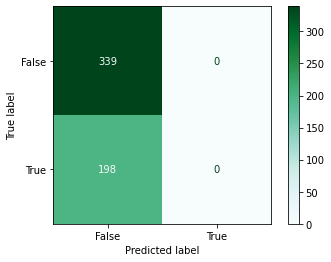

Logistic Model on Full Data Complete in 99.11088020000079 seconds
OrderedDict([('fit_intercept', True), ('solver', 'liblinear')])


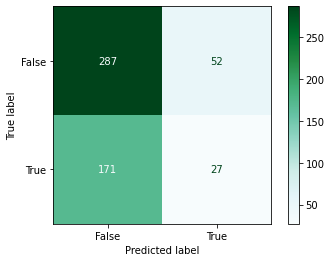

Logistic Model on Data Subset Complete in 55.026936499999465 seconds
OrderedDict([('shrinkage', 0.1), ('solver', 'lsqr')])


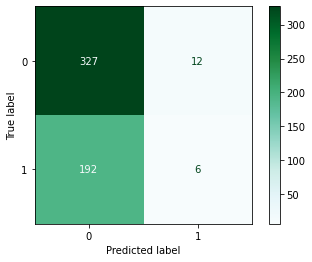

RDA Model on Full Data Complete in 44.71756789999927 seconds
OrderedDict([('shrinkage', 0.8), ('solver', 'lsqr')])


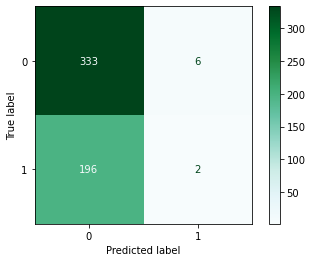

RDA Model on Data Subset Complete in 43.682039899999836 seconds
OrderedDict([('criterion', 'gini'), ('max_depth', 4), ('n_estimators', 500)])


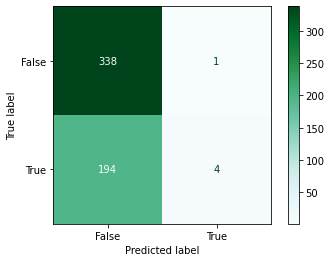

Random Forest Model on Data Subset Complete in 300.44000549999964 seconds
OrderedDict([('criterion', 'friedman_mse'), ('loss', 'exponential'), ('max_depth', 1), ('max_features', 'log2'), ('n_estimators', 250)])


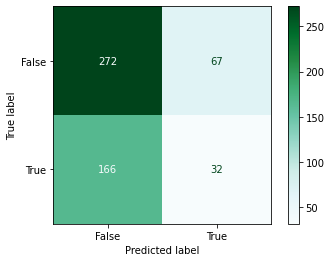

Boosted Trees Model on Full Dataset Complete in 1585.0144845000004 seconds
OrderedDict([('criterion', 'squared_error'), ('loss', 'exponential'), ('max_depth', 1), ('max_features', 'log2'), ('n_estimators', 250)])


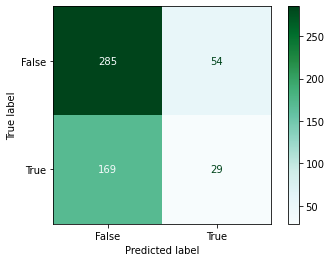

Boosted Trees Model on Data Subset Complete in 1513.5855897000001 seconds


In [22]:
start = timer()
log_accuracy_full = run_logistic(xl_full,yl,graph=True)
end = timer()
print(f'Logistic Model on Full Data Complete in {end-start} seconds')

start = timer()
log_accuracy_part = run_logistic(xl_part,yl,graph=True)
end = timer()
print(f'Logistic Model on Data Subset Complete in {end-start} seconds')

start = timer()
rda_accuracy_full = run_RDA_classification(xl_full,yl,graph=True)
end = timer()
print(f'RDA Model on Full Data Complete in {end-start} seconds')

start = timer()
rda_accuracy_part = run_RDA_classification(xl_part,yl,graph=True)
end = timer()
print(f'RDA Model on Data Subset Complete in {end-start} seconds')

start = timer()
rf_accuracy_part = run_cross_validation_on_classification_RF(xl_part,yl,graph=True)
end = timer()
print(f'Random Forest Model on Data Subset Complete in {end-start} seconds')

start = timer()
boost_accuracy_full = run_cross_validation_on_classification_Boost(xl_full,yl,graph=True)
end = timer()
print(f'Boosted Trees Model on Full Dataset Complete in {end-start} seconds')

start = timer()
boost_accuracy_part = run_cross_validation_on_classification_Boost(xl_part,yl,graph=True)
end = timer()
print(f'Boosted Trees Model on Data Subset Complete in {end-start} seconds')

In [23]:
#create a data frame of the results for analysis
result_aa_list  = [['Logistic Run 1','Full',log_accuracy_full]
                  ,['Logistic Run 2','Partial',log_accuracy_part]
                  ,['RDA Run 1','Full',rda_accuracy_full]
                  ,['RDA Run 2','Partial',rda_accuracy_part]
                  ,['Random Forest Run 1','Partial',rf_accuracy_part]
                  ,['Boosted Trees Run 1','Full',boost_accuracy_full]
                  ,['Boosted Trees Run 2','Partial',boost_accuracy_part]]
results_above_average = pd.DataFrame(result_aa_list,columns=['Model_Name','Data_Used','Accuracy'])
results_above_average.sort_values(['Accuracy'],ascending=[False])

,Model_Name,Data_Used,Accuracy
4,Random Forest Run 1,Partial,0.636872
0,Logistic Run 1,Full,0.631285
3,RDA Run 2,Partial,0.623829
2,RDA Run 1,Full,0.620056
1,Logistic Run 2,Partial,0.584730
6,Boosted Trees Run 2,Partial,0.584730
5,Boosted Trees Run 1,Full,0.566108


In [24]:
full_end = timer()
print(f'Total elapsed time {(full_end-full_start)/60:.5}')

Total elapsed time 1.8e+02


In [26]:
from sklearn import tree
import graphviz

In [28]:
xl_full.columns.values.tolist() #performs best with largest data frames, else use list(xl_full)

['DailyPrecipitation',
 'DailySnowDepth',
 'DailySnowfall',
 'PriorDayAverageDryBulbTemperatureDiff',
 'PriorDayMaximumTemperatureDiff',
 'PriorDayMinimumTemperatureDiff',
 'PriorDayPrecipitationAmt',
 'Prior2DayPrecipitationAmt',
 'PriorDayPrecipitationDiff',
 'Prior2DayPrecipitationDiff',
 'PriorDaySnowfallAmt',
 'PriorDaySnowfallDiff',
 'is_midweek_True',
 'SnowOnGround_True',
 'Precip_12AM-6AM_No Precip',
 'Precip_12AM-6AM_Precip',
 'Precip_6AM-10AM_No Precip',
 'Precip_6AM-10AM_Precip',
 'Precip_6AM-12PM_No Precip',
 'Precip_6AM-12PM_Precip',
 'Precip_10AM-2PM_No Precip',
 'Precip_10AM-2PM_Precip']

In [30]:
list

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
